In [ ]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words=open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1  for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# training split , dev/validation split , test split
# 80% , 10% , 10%

block_size=3 # context length , how many characters  do we take to predict the next one
def build_dataset(words):
  #build the dataset
  X,Y = [],[]

  for w in words:
    context=block_size*[0]
    for ch in w + ".":
      ix=stoi[ch]
      X.append(context)
      Y.append(ix)

      context=context[1:]+[ix]

  X=torch.tensor(X)
  Y=torch.tensor(Y)

  print(X.shape,Y.shape)
  return X,Y

import random
random.seed(42)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr=build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])


torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [ ]:
n_embed=10 # the dimensionality of the character embedding vectors
n_hidden=200 # the number of neurons in the hidden layer of the MLP

g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,n_embed),generator=g)
W1=torch.randn((n_embed*block_size,n_hidden))
# b1=torch.randn((n_hidden))
W2=torch.randn((n_hidden,vocab_size))
b2=torch.randn((vocab_size))


#BATCH NORM PARAMETERS

bngain=torch.ones((1,n_hidden))
bnbias=torch.zeros((1,n_hidden))


bnmean_running=torch.zeros((1,n_hidden))
bnstd_running=torch.ones((1,n_hidden))

parameters=[C,W1,W2,b2,bngain,bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad=True


12097


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation  #bias not required as it is being subtracted out

  #Batch Normalization

  bnmeani = hpreact.mean(0,keepdim=True)
  bnstdi = hpreact.std(0,keepdim=True)


  hpreact=bngain*((hpreact-bnmeani)/bnstdi)+bnbias

  with torch.no_grad():
    bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
    bnstd_running  = 0.999*bnstd_running + 0.001*bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 18.6266
  10000/ 200000: 2.6241
  20000/ 200000: 2.3683
  30000/ 200000: 2.5030
  40000/ 200000: 2.3895
  50000/ 200000: 2.5295
  60000/ 200000: 2.2546
  70000/ 200000: 2.3906
  80000/ 200000: 2.4312
  90000/ 200000: 2.2183
 100000/ 200000: 2.2427
 110000/ 200000: 2.5483
 120000/ 200000: 2.3848
 130000/ 200000: 2.2433
 140000/ 200000: 1.8807
 150000/ 200000: 1.9532
 160000/ 200000: 2.7401
 170000/ 200000: 2.2609
 180000/ 200000: 2.1666
 190000/ 200000: 2.1204


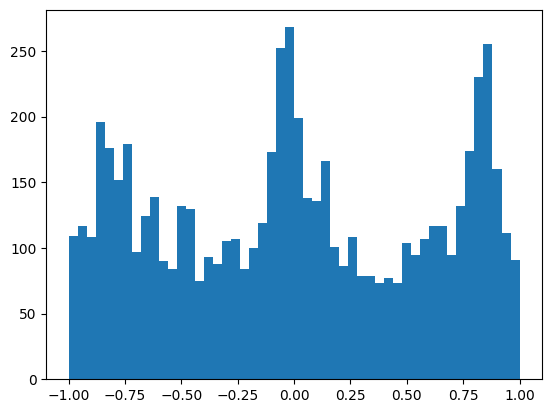

In [ ]:
plt.hist(h.view(-1).tolist(),50);

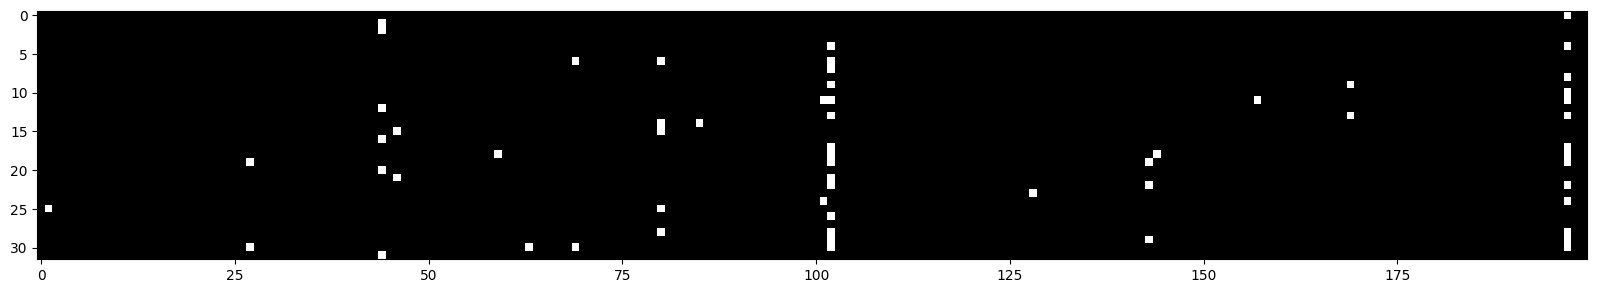

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

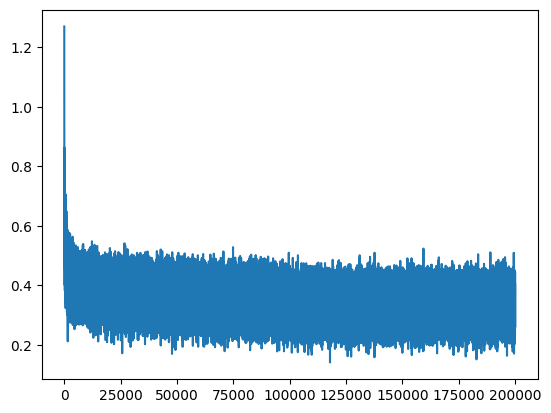

In [ ]:
plt.plot(lossi)

In [ ]:
#calibrate the batch norm at the end of the training
with torch.no_grad():
  #pass the training set through
  emb=C[Xtr]
  embcat=emb.view(emb.shape[0],-1)
  hpreact=embcat@W1#+b1

  #measure the mean/standard deviation over the entire training set

  bnmean=hpreact.mean(0,keepdim=True)
  bnstd=hpreact.std(0,keepdim=True)

In [ ]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
  x,y={
      'train':(Xtr,Ytr),
      'val':(Xdev,Ydev),
      'test':(Xte,Yte)
  }[split]
  embed=C[x] #(N,block_size,embed)

  embcat=embed.view(embed.shape[0],-1) # concat into (N,block_size*n_embed)
  hpreact=embcat@W1#+b1
  hpreact=bngain*((hpreact-bnmean_running)/bnstd_running)+bnbias
  h=torch.tanh(hpreact) #(N,n_hidden)

  logits=h@W2+b2
  loss=F.cross_entropy(logits,y)

  print(split,loss.item())

split_loss('train')
split_loss('val')




train 2.154266834259033
val 2.4030351638793945


In [ ]:
g=torch.Generator().manual_seed(214783647+10000)
for _ in range(20):
  out=[]
  context=[0]*block_size
  while True:
    emb=C[torch.tensor([context])] # (1,block_size,n_embed)
    hpreact=emb.view(1,-1)@W1#+b1
    hpreact=bngain*((hpreact-bnmean_running)/bnstd_running)+bnbias


    h=torch.tanh(hpreact)
    logits=h@W2+b2
    probs=F.softmax(logits,dim=1)

    #sample from the distribution
    ix=torch.multinomial(probs,num_samples=1,generator=g).item()

    context=context[1:]+[ix]
    out.append(ix)

    if ix==0:
      break


  print(''.join(itos[ix] for ix in out))

deroonsoch.
ruriph.
sucabellena.
den.
emeraica.
zatelbrostifa.
yurigin.
reni.
tabin.
ire.
cton.
evis.
one.
riloie.
fmarleyah.
grithar.
gra.
ariah.
namiya.
cachri.


# Pytorchify the Network

In [ ]:
class Linear:

  def __init__(self,fan_in,fan_out,bias=True):
    self.weight=torch.randn((fan_in,fan_out),generator=g)/(fan_in**0.5)  #kaining initialization
    self.bias=torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out=x@self.weight
    if self.bias is not None:
      self.out+=self.bias

    return self.out


  def parameters(self):
    return [self.weight]+([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self,dim,eps=1e-5,momentum=1e-1):
    self.eps=eps
    self.dim=dim
    self.momentum=momentum

    self.training=True

    #parameters(trained with backprop)

    self.gamma=torch.ones(dim)
    self.beta=torch.zeros(dim)

    #buffers(trained with a running ' momentun update')
    self.running_mean=torch.zeros(dim)
    self.running_var=torch.ones(dim)


  def __call__(self,x):
    #calculate the forward pass
    if self.training:
      xmean=x.mean(0,keepdim=True) #batch mean
      xvar=x.var(0,keepdim=True)   #batch variance
    else :
      xmean=self.running_mean
      xvar=self.running_var

    xhat=(x-xmean)/torch.sqrt(xvar+self.eps)  #normalize to unit variance

    self.out=self.gamma*xhat+self.beta

    #update the buffers

    if self.training:
      with torch.no_grad(): # torch.no grad context manager so that pytorch does not create a computational graph. This saves memory
        self.running_mean=(1-self.momentum)*self.running_mean + self.momentum*xmean
        self.running_var=(1-self.momentum)*self.running_var+ self.momentum*xvar

    return self.out


  def parameters(self):
    return [self.gamma,self.beta]



class Tanh:
  def __call__(self,x):
    self.out=torch.tanh(x)
    return self.out

  def parameters(self):
    return []







In [ ]:
n_embed=10 # the dimensonality of character embedding vectors
n_hidden=100 # the number of neurons in the hidden layer of MLP
g= torch.Generator().manual_seed(2147483647)

C= torch.randn((vocab_size,n_embed), generator=g)

layers=[
    Linear(n_embed*block_size,n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), Tanh(),
    Linear(n_hidden,vocab_size),
]

with torch.no_grad():
  # last layer : make less confident
  layers[-1].weight*=0.1

  # all other layers apply gain

  for layer in layers:
    if isinstance(layer,Linear):
      layer.weight*=(5/3)


parameters=[C]+[p for layer in layers for p in layer.parameters()]

print (sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad=True


46497


In [ ]:
max_steps=200000
batch_size=32
lossi=[]
ud=[]
for i in range(max_steps):

  #minibatch construct

  ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
  Xb,Yb=Xtr[ix],Ytr[ix]


  #forward pass
  emb=C[Xb]

  x=emb.view(emb.shape[0],-1)

  for layer in layers:
    x=layer(x)

  loss=F.cross_entropy(x,Yb)

  #backward pass

  for layer in layers:
    layer.out.retain_grad()

  for p in parameters:
    p.grad=None

  loss.backward()

  #update

  lr= 1e-1 if i <100000 else 1e-2

  for p in parameters:
    p.data+=-lr*p.grad



  ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])


  #track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # break


# break
  if i >1000:
    break



      0/ 200000: 3.3424


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.12%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated: 2.44%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%


Text(0.5, 1.0, 'activation distribution')

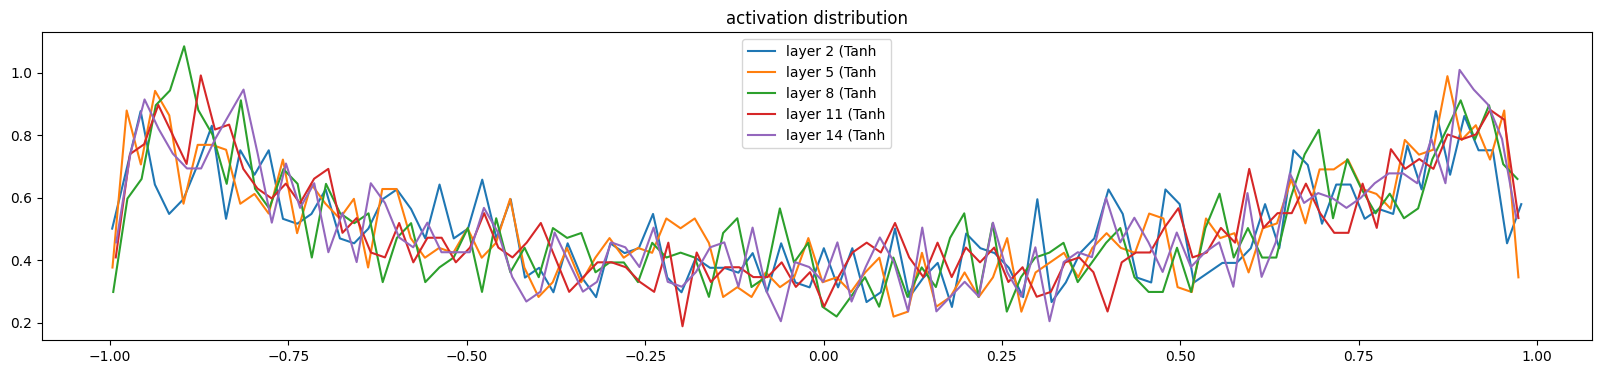

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

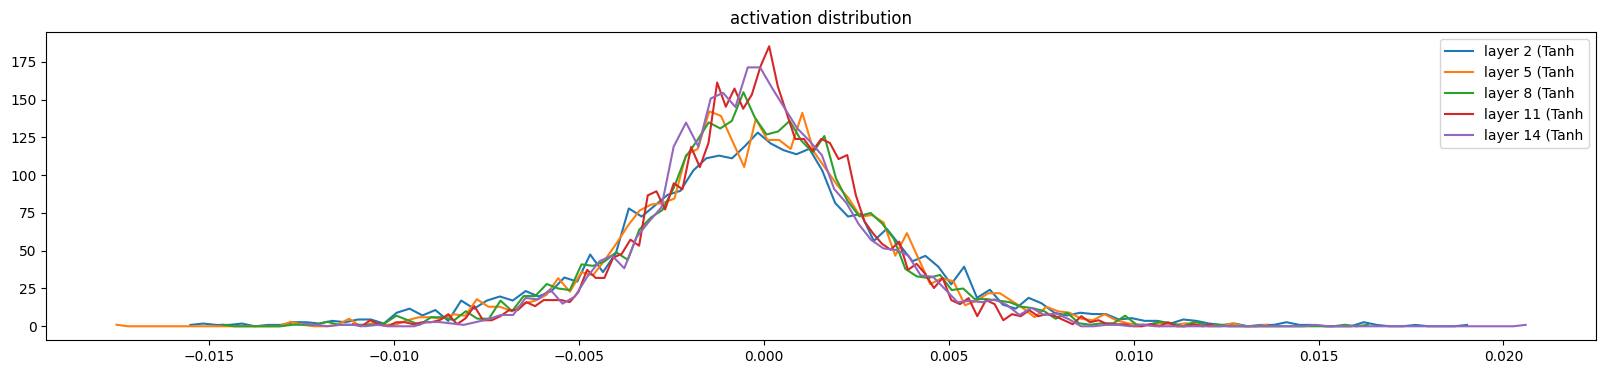

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

weight   (27, 10) | mean -0.000000 | std 1.017454e-02 | grad:data ratio 1.016421e-02
weight  (30, 100) | mean -0.000253 | std 9.128213e-03 | grad:data ratio 2.920518e-02
weight (100, 100) | mean +0.000028 | std 7.558879e-03 | grad:data ratio 4.522101e-02
weight (100, 100) | mean +0.000005 | std 6.895030e-03 | grad:data ratio 4.088434e-02
weight (100, 100) | mean -0.000010 | std 6.897519e-03 | grad:data ratio 4.109383e-02
weight (100, 100) | mean -0.000014 | std 6.294376e-03 | grad:data ratio 3.748442e-02
weight  (100, 27) | mean +0.000132 | std 1.247965e-02 | grad:data ratio 7.484618e-02


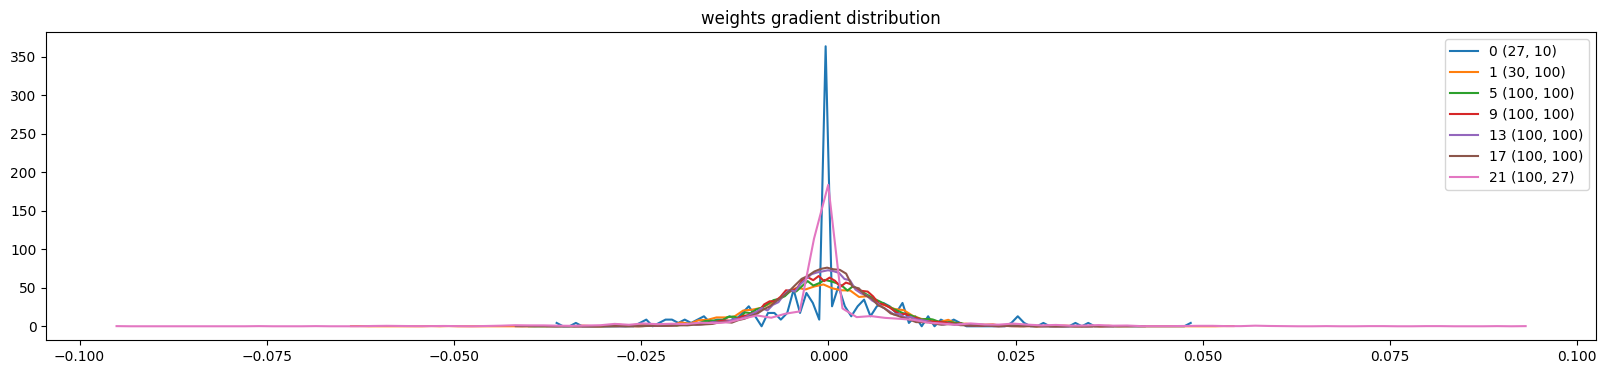

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

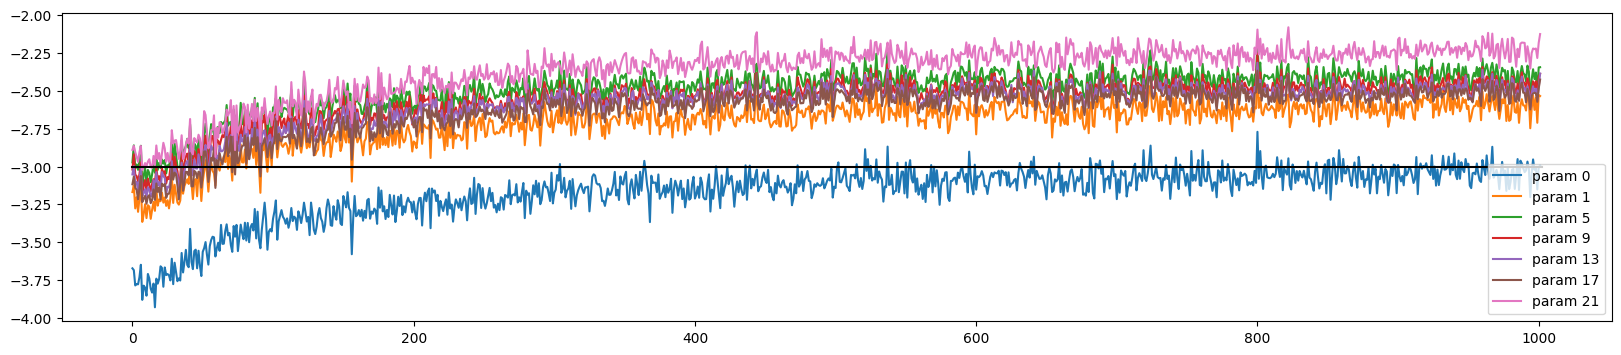

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [ ]:
n_embed=10 # the dimensonality of character embedding vectors
n_hidden=100 # the number of neurons in the hidden layer of MLP
g= torch.Generator().manual_seed(2147483647)

C= torch.randn((vocab_size,n_embed), generator=g)

layers=[
    Linear(n_embed*block_size,n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size),BatchNorm1d(vocab_size)
]

with torch.no_grad():
  # last layer : make less confident
  layers[-1].gamma*=0.1

  # all other layers apply gain

  # for layer in layers:
  #   if isinstance(layer,Linear):
  #     layer.weight*=(5/3)


parameters=[C]+[p for layer in layers for p in layer.parameters()]

print (sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad=True


47551


In [ ]:
max_steps=200000
batch_size=32
lossi=[]
ud=[]
for i in range(max_steps):

  #minibatch construct

  ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
  Xb,Yb=Xtr[ix],Ytr[ix]


  #forward pass
  emb=C[Xb]

  x=emb.view(emb.shape[0],-1)

  for layer in layers:
    x=layer(x)

  loss=F.cross_entropy(x,Yb)

  #backward pass

  for layer in layers:
    layer.out.retain_grad()

  for p in parameters:
    p.grad=None

  loss.backward()

  #update

  lr= 1e-1 if i <100000 else 1e-2

  for p in parameters:
    p.data+=-lr*p.grad



  ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])


  #track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # break


# break
  if i >1000:
    break



      0/ 200000: 3.3163


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.41%
layer 11 (      Tanh): mean -0.01, std 0.65, saturated: 2.06%
layer 14 (      Tanh): mean -0.01, std 0.65, saturated: 1.94%


Text(0.5, 1.0, 'activation distribution')

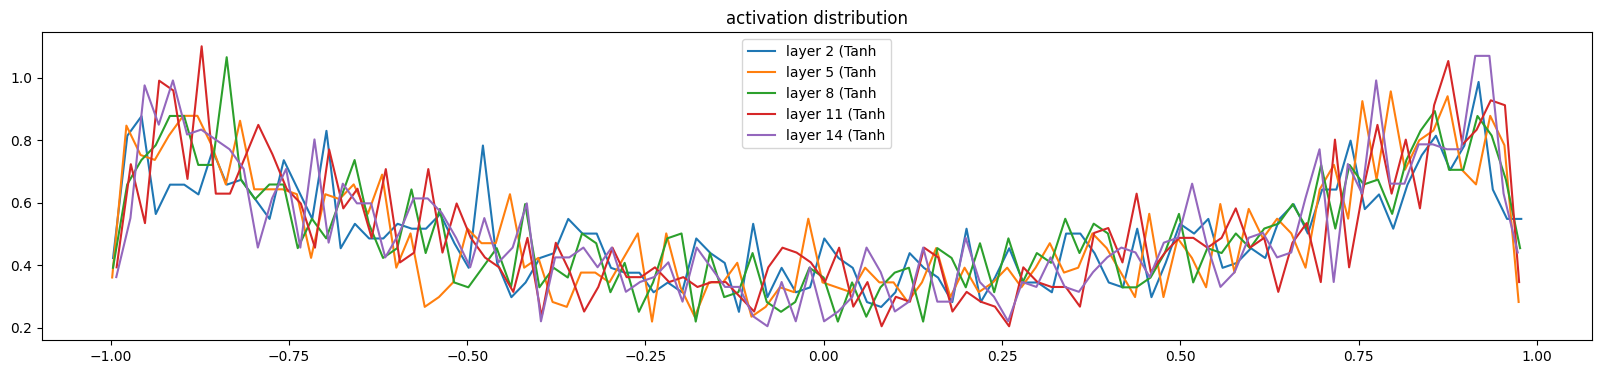

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

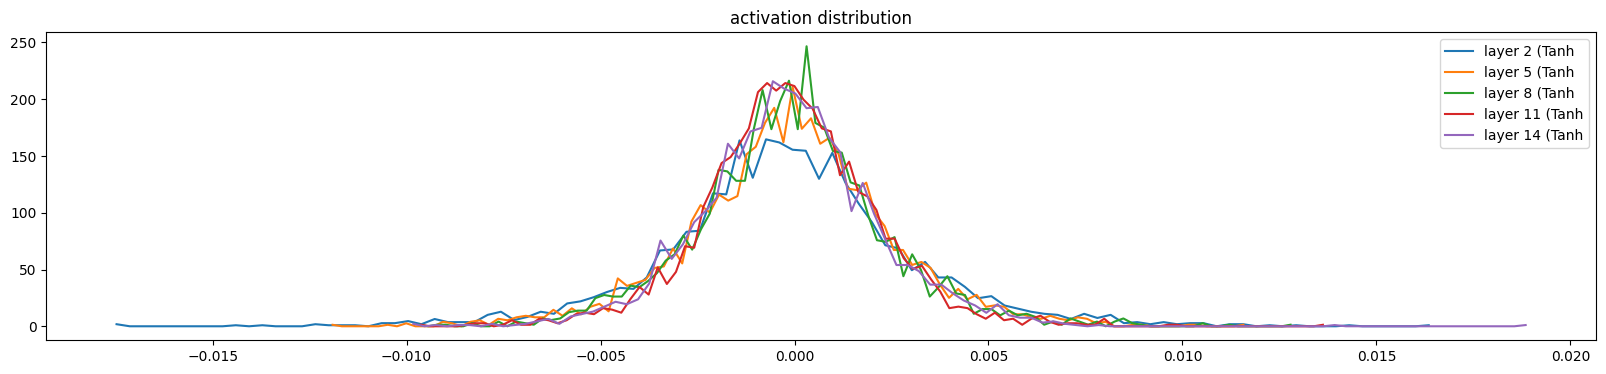

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

weight   (27, 10) | mean +0.000000 | std 9.864048e-03 | grad:data ratio 9.854198e-03
weight  (30, 100) | mean -0.000340 | std 1.198980e-02 | grad:data ratio 6.328271e-02
weight (100, 100) | mean +0.000098 | std 8.970274e-03 | grad:data ratio 8.753373e-02
weight (100, 100) | mean -0.000130 | std 7.491715e-03 | grad:data ratio 7.297423e-02
weight (100, 100) | mean +0.000030 | std 7.033607e-03 | grad:data ratio 6.900306e-02
weight (100, 100) | mean +0.000072 | std 6.391737e-03 | grad:data ratio 6.278668e-02
weight  (100, 27) | mean +0.000124 | std 1.313910e-02 | grad:data ratio 1.259934e-01


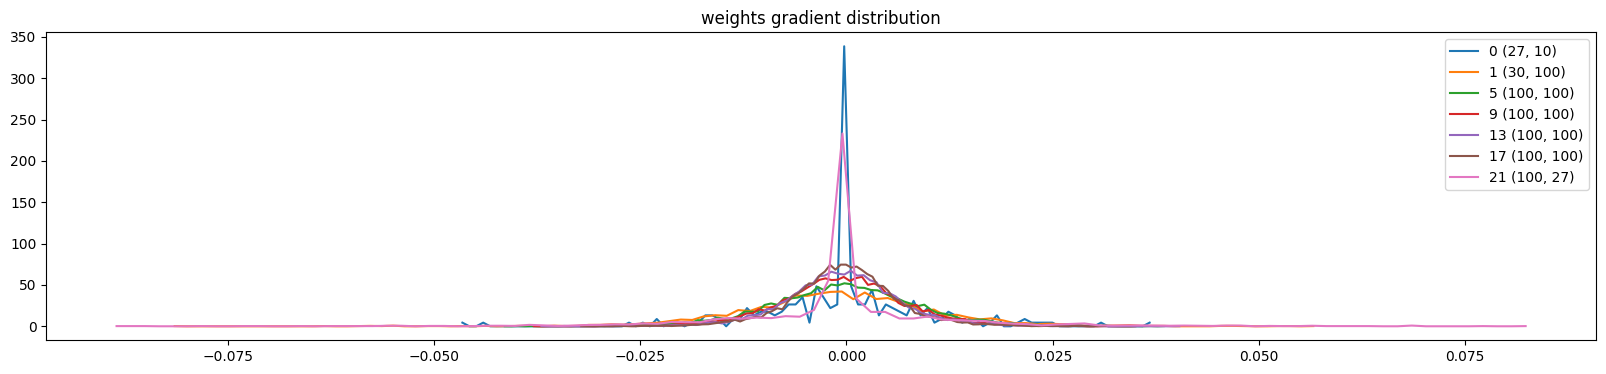

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

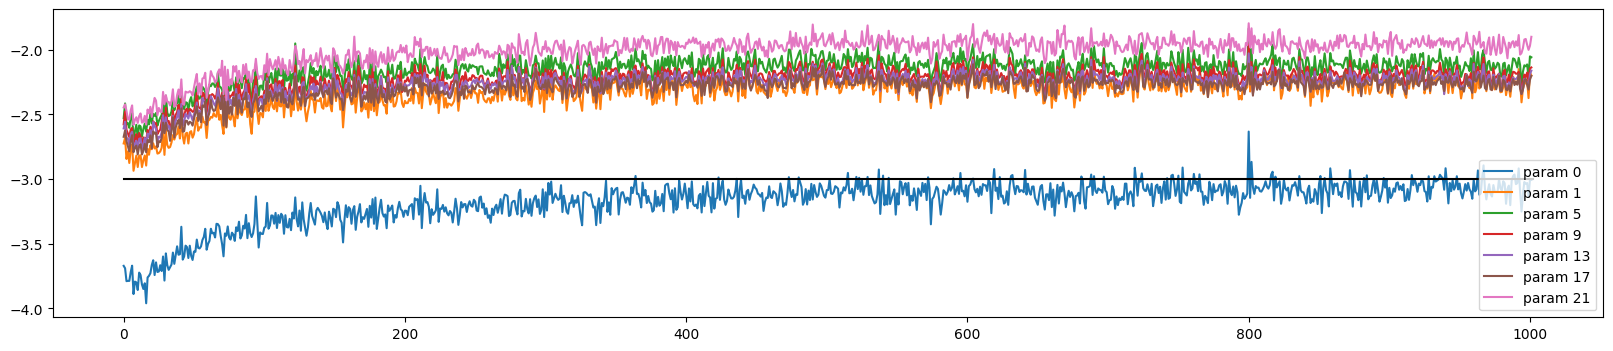

In [ ]:
#update to data ratios !!!!

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.3560030460357666
val 2.5750722885131836


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mria.
kmyanzeee.
madyn.
alarethrstendrlen.
aderedielii.
shi.
jen.
edeineananaraelyn.
malara.
nosadbergshiries.
kin.
reneliqxnteuof.
uya.
ged.
riy.
julyeh.
hraejahsanyanahilina.
yarsui.
zajalveu.
en.


## BONUS CONTENT

In [ ]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):

  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [ ]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [ ]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
